# Gaussianization Flows (Details)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse

# Plot utilities
from rbig_jax.custom_types import ImageShape
from rbig_jax.plots import plot_image_grid


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In this demonstration, we will be using the "mnist" dataset.

In [3]:
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load("mnist", split=split, shuffle_files=True)
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f6c248eae80>)

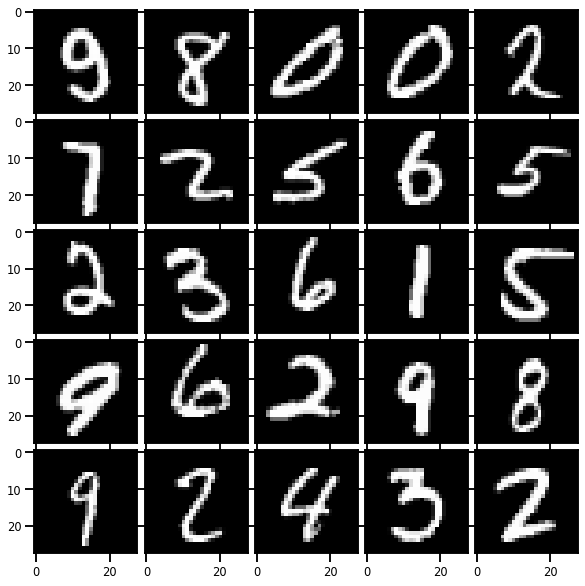

In [7]:
# train/valid dataset loaders
train_ds = load_dataset(tfds.Split.TRAIN, 10_000)
valid_ds = load_dataset(tfds.Split.TEST, 10_000)

# demo batch
demo_batch = next(train_ds)

# plot batch of images
plot_image_grid(demo_batch["image"])

### Preprocessing Steps

1. Dequantize the variables

Basically add some uniform noise to help with training.

2. Normalize the pixels

We constrain the pixels to be from $[0, 256)$ to $[0, 1)$.

In [8]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:

    # select image from tfds
    data = batch["image"].astype(np.float32)

    # dequantize pixels (training only)
    if prng_key is not None:
        # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
        data += jax.random.uniform(prng_key, data.shape)

    # flatten image data
    data = rearrange(data, "B H W C -> B (H W C)")

    return data / 256.0  # Normalize pixel values from [0, 256) to [0, 1).

def eval_fn(model: dataclass, batch: Batch) -> Array:

    # prepare data
    data = prepare_data(batch)

    # negative log likelihood loss
    nll_loss = model.score(data)

    return nll_loss

#### Demo

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f6ae0447d00>)

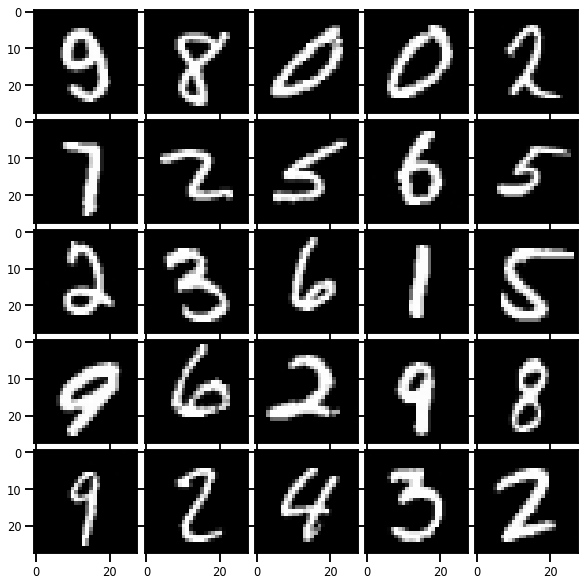

In [9]:
# create key
rng, prng_key = jax.random.split(KEY, num=2)

# prep the data
demo_data_prepped = prepare_data(demo_batch, prng_key=prng_key)

# plot image grid
image_shape = ImageShape(C=1, H=28, W=28)
plot_image_grid(demo_data_prepped, image_shape)

## Model

In [14]:
from rbig_jax.models import RBIG

# initialization data
X = np.array(demo_data_prepped)

# a lot of parameters...
support_extension = 20
precision = 1_000
eps = 1e-5
method = "kde"
# Histogram specific params
nbins = None
alpha = 1e-5
# KDE specific params
bw = "scott"

# info reduction loss parameters
max_layers = 1_000
zero_tolerance = 60
p = 0.25
base = 2

# initialize the max layers parameters
verbose = True
n_layers_remove = 40
interval = 10

# everything (makes it fast...)
jitted = True

In [16]:
X_g, rbig_model = RBIG(
    X=X,
    support_extension=support_extension,
    method=method,
    precision=precision,
    alpha=alpha,
    nbins=nbins,
    bw=bw,
    eps=eps,
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
    verbose=verbose,
    n_layers_remove=n_layers_remove,
    interval=interval,
    jitted=jitted,
)

Layer 10 - Cum. Info Reduction: 1267.408 - Elapsed Time: 96.8972 secs
Layer 20 - Cum. Info Reduction: 1279.651 - Elapsed Time: 192.2094 secs
Layer 30 - Cum. Info Reduction: 1283.270 - Elapsed Time: 287.7700 secs
Layer 40 - Cum. Info Reduction: 1289.027 - Elapsed Time: 383.1523 secs
Layer 50 - Cum. Info Reduction: 1293.820 - Elapsed Time: 478.5534 secs
Layer 60 - Cum. Info Reduction: 1298.745 - Elapsed Time: 573.7941 secs
Layer 70 - Cum. Info Reduction: 1299.068 - Elapsed Time: 669.1676 secs
Layer 80 - Cum. Info Reduction: 1302.812 - Elapsed Time: 765.2800 secs
Layer 90 - Cum. Info Reduction: 1304.688 - Elapsed Time: 869.7281 secs
Layer 100 - Cum. Info Reduction: 1306.296 - Elapsed Time: 972.5137 secs
Layer 110 - Cum. Info Reduction: 1307.712 - Elapsed Time: 1086.8340 secs
Layer 120 - Cum. Info Reduction: 1308.211 - Elapsed Time: 1200.2867 secs
Layer 130 - Cum. Info Reduction: 1310.528 - Elapsed Time: 1314.8649 secs
Layer 140 - Cum. Info Reduction: 1311.207 - Elapsed Time: 1428.5059 sec

## Loss Function

### Information Loss

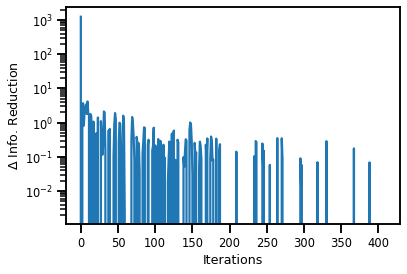

In [23]:
fig, ax = plt.subplots()
ax.plot(rbig_model.info_loss)
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction", yscale="log")
plt.show()

### Negative-Log Likelihood

In [24]:
# nll for the old model
nll = rbig_model.score(X)

print(f"NLL: {nll:.4f}")

NLL: 37080.9219


In [ ]:
# demo batch
eval_batch = next(valid_ds)

nll = eval_fn(rbig_model, eval_batch)

print(f"NLL (Valid): {nll:.4f}")

### Forward Transformation

In [17]:
%%time

# forward propagation for data
X_demo_g = rbig_model.forward(demo_data_prepped)

# plot demo images
# plot image grid
image_shape = ImageShape(C=1, H=28, W=28)
plot_image_grid(X_demo_g, image_shape)

KeyboardInterrupt: 

In [22]:
fig = corner.corner(np.array(X_demo_g[:, :5]), color="red")

NameError: name 'X_demo_g' is not defined

### Inverse Transformation

In [19]:
%%time

# forward propagation for data
X_demo_approx = rbig_model.inverse(X_demo_g[:100])

# plot demo images
# plot image grid
image_shape = ImageShape(C=1, H=28, W=28)
plot_image_grid(X_demo_approx, image_shape)

NameError: name 'X_demo_g' is not defined

In [ ]:
fig = corner.corner(np.array(X_demo_approx[:, :5]), color="red")

## Sampling

CPU times: user 40.3 s, sys: 2.46 s, total: 42.8 s
Wall time: 31 s


(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f6a5479f5e0>)

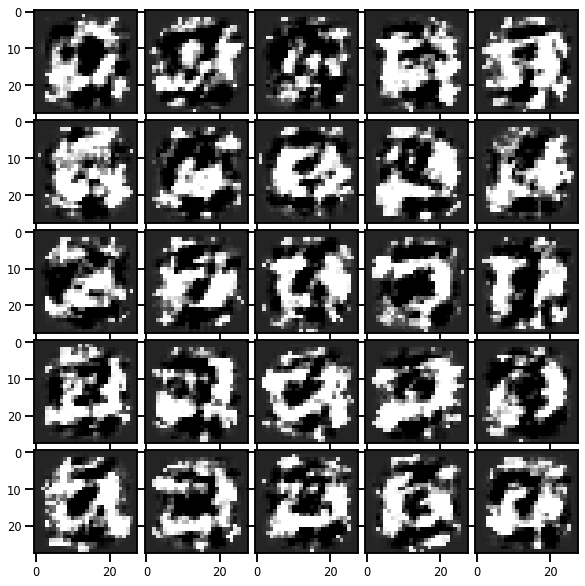

In [20]:
%%time

n_gen_samples = 50
X_samples = rbig_model.sample(seed=123, n_samples=n_gen_samples)

# plot
plot_image_grid(X_samples, image_shape)

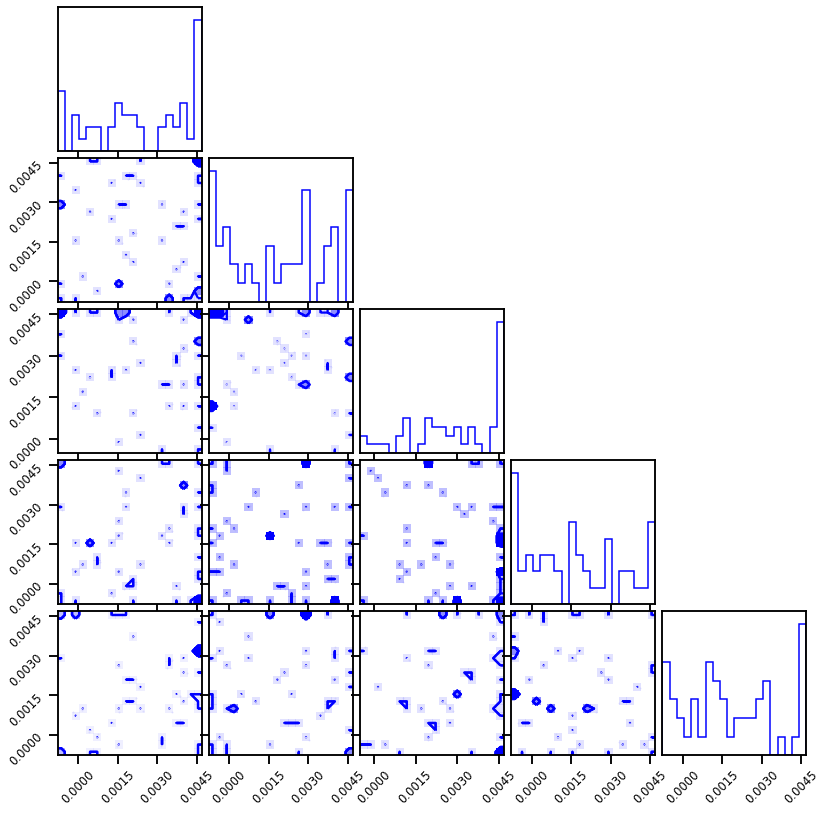

In [21]:
fig = corner.corner(np.array(X_samples[:, :5]), color="Blue")

## Each Layer

#### Original

In [ ]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    

#### Trained Model

In [ ]:

X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(final_bijector.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    
    

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect('equal', 'box')
plt.tight_layout()

## Saving/Loading Model

In [101]:
import joblib

#### Save Model

In [102]:
joblib.dump(gf_model, "gf_model_mnist.pickle")

['gf_model_mnist.pickle']

#### Load Model

In [103]:
gf_model_ = joblib.load("gf_model_mnist.pickle")